<a href="https://colab.research.google.com/github/jellyho/AI_Learning_jellyho/blob/main/7_Data_Preprocessing_PCA%26LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. PCA로 주성분 추출하기 (비지도 차원 축소)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

테스트 셋 분리하고 표준화

In [2]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

from sklearn.preprocessing import StandardScaler as SC
sc = SC()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

공분산 행렬 구해서 고윳값과 고유벡터 구하기, 그리고 그 중에서 분산이 제일 높은 벡터 두개만 구해서 투영 행렬을 구성하고 투영해서 N*2 차원의 행렬로 변경, 산점도 그리기

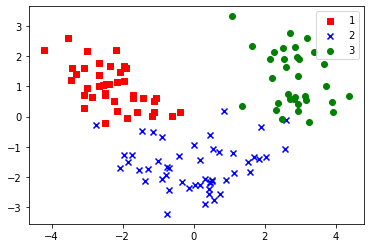

In [3]:
cov_matrix = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

X_train_pca = X_train_std.dot(w)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for i, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_pca[y_train==i, 0], X_train_pca[y_train==i, 1], c=c, label=i, marker=m)

plt.legend(loc='best')
plt.show()

사이킷런으로 사용하기

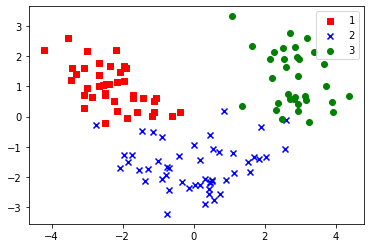

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for i, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_pca[y_train==i, 0], X_train_pca[y_train==i, 1], c=c, label=i, marker=m)

plt.legend(loc='best')
plt.show()

이 상태로 선형 분류기를 사용하면 잘 분류가 될 것 같다.

2. LDA로 데이터 압축하기

먼저 클래스별 특성의 평균을 구해서 평균 벡터를 구해준다.

In [5]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
  mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
  print(f"{label} {mean_vecs[label-1]}")

1 [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
2 [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
3 [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


클래스 내 산포 행렬, 클래스 간 산포 행렬 구하기

In [6]:
d = 13 # 특성 개수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
  class_scatter = np.cov(X_train_std[y_train==label].T, bias=True)
  S_W += class_scatter

mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)

S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
  n = X_train[y_train == i + 1, :].shape[0]
  mean_vec = mean_vec.reshape(d, 1)
  S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

eigen_vals_lda, eigen_vecs_lda = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs_lda = [(np.abs(eigen_vals_lda[i]), eigen_vecs_lda[:, i]) for i in range(len(eigen_vals_lda))]
eigen_pairs_lda = sorted(eigen_pairs_lda, key = lambda k: k[0], reverse=True)

for eigen_val_lda in eigen_pairs_lda:
  print(eigen_val_lda[0], eigen_val_lda[1])

358.0042070133659 [-0.1484+0.j  0.091 +0.j -0.0168+0.j  0.1487+0.j -0.0165+0.j  0.1912+0.j
 -0.7333+0.j -0.0751+0.j  0.002 +0.j  0.2953+0.j -0.0327+0.j -0.3539+0.j
 -0.3918+0.j]
177.07768640666228 [-0.4093+0.j -0.1583+0.j -0.3536+0.j  0.322 +0.j -0.0813+0.j  0.0841+0.j
  0.2828+0.j -0.0099+0.j  0.0902+0.j -0.2168+0.j  0.274 +0.j -0.0133+0.j
 -0.5954+0.j]
2.842170943040401e-14 [ 0.7518+0.j -0.0838+0.j -0.2405+0.j  0.2514+0.j -0.0584+0.j  0.1026+0.j
  0.0112+0.j -0.0248+0.j  0.0608+0.j -0.0733+0.j  0.1753+0.j -0.0947+0.j
 -0.4932+0.j]
2.4212577013065712e-14 [-0.726 +0.j  0.0662+0.j  0.3181+0.j -0.2456+0.j  0.0801+0.j -0.1945+0.j
  0.0085+0.j  0.0427+0.j -0.0659+0.j  0.0875+0.j -0.1418+0.j  0.1547+0.j
  0.4526+0.j]
1.7893216852990086e-14 [ 0.3439+0.j  0.1126+0.j  0.4581+0.j  0.0339+0.j -0.2466+0.j -0.1634+0.j
 -0.2133+0.j  0.0907+0.j -0.0773+0.j -0.3556+0.j -0.2345+0.j  0.5739+0.j
  0.0125+0.j]
1.5846823701627717e-14 [ 0.5263+0.j     -0.0246-0.1027j -0.1105-0.4922j  0.0796+0.1016j
  0.029

0이 아닌 고윳값이 두개만 있음. 나머지는 부동 소수점 계산 오류로, 원래는 0이라고 보는게 맞음

이 결과를 토대로 변환 행렬을 제작한다.

In [7]:
w_lda = np.hstack((eigen_pairs_lda[0][1][:, np.newaxis].real, eigen_pairs_lda[1][1][:, np.newaxis].real))

print(w_lda)

[[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


새로운 샘플 공간으로 투영!

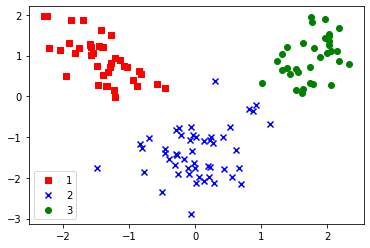

In [8]:
X_train_lda = X_train_std.dot(w_lda)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for i, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda[y_train==i, 0], X_train_lda[y_train==i, 1] * -1, c=c, label=i, marker=m)

plt.legend(loc='best')
plt.show()

더욱 선형적으로 구분하기가 쉬워졌다!

이제 사이킷런으로 LDA 실행하기

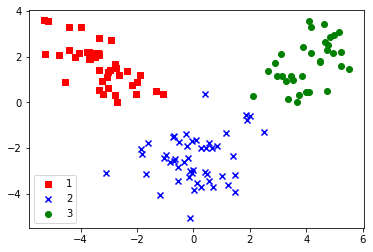

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda_sklearn = lda.fit_transform(X_train_std, y_train)

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for i, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda_sklearn[y_train==i, 0], X_train_lda_sklearn[y_train==i, 1], c=c, label=i, marker=m)

plt.legend(loc='best')
plt.show()

커널 PCA로 비선형적 데이터를 선형적으로 구분 가능한 공간으로 변경

In [11]:
from sklearn.decomposition import KernelPCA
kpca =KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)